### import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as misc
import os, time

### parameters

In [2]:
BATCH_SIZE = 1
IMAGE_H = 256
IMAGE_W = 256

CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1e-2

COCO_PATH = '/home/minsisi/COCO_DATASET/train2014/'
DATA_NUM = 30000
EPOCH = 1
CHECK_POINT = 5000
LR = 1e-4

#  28,000 style images
STYLE_PATH = '/home/minsisi/KAGGLE_STYLE_TRAIN_IMAGES/'
# STYLE_PATH = 'style_images/'
STYLE_NAME_LIST =os.listdir(STYLE_PATH)
STYLE_NUM = len(STYLE_NAME_LIST)

### new function for multi style transfer

In [3]:
def AdaIN(content,style,alpha,epsilon=1e-5):
    c_mu, c_sig_sq = tf.nn.moments(content,axes=[1,2],  keep_dims=True)
    s_mu, s_sig_sq = tf.nn.moments(style,axes=[1,2],  keep_dims=True)
    temp = tf.nn.batch_normalization(content, c_mu, c_sig_sq, s_mu, tf.sqrt(s_sig_sq),epsilon)
    return alpha * temp + (1-alpha) * (content)

In [4]:
def calc_sty_loss(target, style):
    # target, style : relu1,2,3,4 's output f
    losses = list()
    for t,s in list(zip(target, style)):
        t_mu, t_sig_sq = tf.nn.moments(t, axes=[1,2], keep_dims=True)
        s_mu, s_sig_sq = tf.nn.moments(s, axes=[1,2], keep_dims=True)

        mu_loss = tf.reduce_sum(tf.square(t_mu - s_mu))
        sig_loss = tf.reduce_sum(tf.square(tf.sqrt(t_sig_sq) -tf.sqrt(s_sig_sq)))
        
        loss = (mu_loss+ sig_loss) / tf.cast(tf.size(mu_loss), tf.float32)
        losses.append(loss)
        
    return sum(losses)
            

### for image 

In [5]:
# # for image process
def visualize_img(x):
    return np.clip(x, 0, 255).astype('uint8')

def read_img(img_path):
    img = misc.imread(img_path)
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        img = np.dstack((img,img,img))
    
    return misc.imresize(img, (IMAGE_H,IMAGE_W,3))

### tensor preprocess

In [6]:
# mean value 
def tf_rev_prosess(out_img):
    return tf.stack([ out_img[:,:,:,0] + 103.939, out_img[:,:,:,1] + 116.779,out_img[:,:,:,2] + 123.68], axis=3)

def tf_preprocess(out_img):
    return tf.stack([ out_img[:,:,:,0] - 103.939, out_img[:,:,:,1] - 116.779,out_img[:,:,:,2] - 123.68 ], axis=3)

### for vgg net

In [7]:
# for vgg network
def conv2d(x, W,padding='SAME'):
        return tf.nn.conv2d(x,W, strides=[1, 1, 1, 1], padding=padding)

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def weight_tensor(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.1))


### vgg net

In [8]:
class vgg_19:
    def __init__(self):
        # load vgg weights
        vggW = np.load('vgg19_weights.npy')
        self.W_CONV1_1 = tf.constant(vggW[0])
        self.b_CONV1_1 = tf.constant(vggW[1])
        self.W_CONV1_2 = tf.constant(vggW[2])
        self.b_CONV1_2 = tf.constant(vggW[3])

        self.W_CONV2_1 = tf.constant(vggW[4])
        self.b_CONV2_1 = tf.constant(vggW[5])
        self.W_CONV2_2 = tf.constant(vggW[6])
        self.b_CONV2_2 = tf.constant(vggW[7])

        self.W_CONV3_1 = tf.constant(vggW[8])
        self.b_CONV3_1 = tf.constant(vggW[9])
        self.W_CONV3_2 = tf.constant(vggW[10])
        self.b_CONV3_2 = tf.constant(vggW[11])
        self.W_CONV3_3 = tf.constant(vggW[12])
        self.b_CONV3_3 = tf.constant(vggW[13])
        self.W_CONV3_4 = tf.constant(vggW[14])
        self.b_CONV3_4 = tf.constant(vggW[15])

        self.W_CONV4_1 = tf.constant(vggW[16])
        self.b_CONV4_1 = tf.constant(vggW[17])
        self.W_CONV4_2 = tf.constant(vggW[18])
        self.b_CONV4_2 = tf.constant(vggW[19])
        self.W_CONV4_3 = tf.constant(vggW[20])
        self.b_CONV4_3 = tf.constant(vggW[21])
        self.W_CONV4_4 = tf.constant(vggW[22])
        self.b_CONV4_4 = tf.constant(vggW[23])

        self.W_CONV5_1 = tf.constant(vggW[24])
        self.b_CONV5_1 = tf.constant(vggW[25])
        self.W_CONV5_2 = tf.constant(vggW[26])
        self.b_CONV5_2 = tf.constant(vggW[27])

        del(vggW)
        
    def encoder(self, vggx):
        
        h_conv1_1 = tf.nn.relu(conv2d(vggx, self.W_CONV1_1) + self.b_CONV1_1)
        h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, self.W_CONV1_2) + self.b_CONV1_2)
        h_pool1 = avg_pool_2x2(h_conv1_2)

        h_conv2_1 = tf.nn.relu(conv2d(h_pool1,   self.W_CONV2_1) + self.b_CONV2_1)
        h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, self.W_CONV2_2) + self.b_CONV2_2)
        h_pool2 = avg_pool_2x2(h_conv2_2)

        h_conv3_1 = tf.nn.relu(conv2d(h_pool2,   self.W_CONV3_1) + self.b_CONV3_1)
        h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, self.W_CONV3_2) + self.b_CONV3_2)
        h_conv3_3 = tf.nn.relu(conv2d(h_conv3_2, self.W_CONV3_3) + self.b_CONV3_3)
        h_conv3_4 = tf.nn.relu(conv2d(h_conv3_3, self.W_CONV3_4) + self.b_CONV3_4)
        h_pool3 = avg_pool_2x2(h_conv3_4)

        h_conv4_1 = tf.nn.relu(conv2d(h_pool3,   self.W_CONV4_1) + self.b_CONV4_1)
        
        return [h_conv1_1, h_conv2_1, h_conv3_1, h_conv4_1]
    
    def _conv_block(self,h,num,resize=True):
        _,s,s,ch = h.get_shape().as_list()
        new_ch = int(ch/2)
        
        for i in range(num):
            # not use pooling, use resize            
            if resize :
                h = tf.image.resize_images(h,[int(s*2), int(s*2)], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR )

            h = tf.pad(h, [[0,0],[1,1],[1,1],[0,0]], mode='REFLECT')
            h = tf.nn.relu(tf.contrib.layers.conv2d(h, new_ch, [3,3], padding='VALID'))
            
        return h
        
    def decoder(self, h):
        # decoder mirrors the encoder
        
        #relu 4
        h= self._conv_block(h, 1)
        
        # relu 3
        h = self._conv_block(h,4)
        
        # relu 2
        h = self._conv_block(h,2)
        
        # relu 1
        h = self._conv_block(h,1,resize=False)
        h = tf.pad(h, [[0,0],[1,1],[1,1],[0,0]], mode='REFLECT')
        h = tf.contrib.layers.conv2d(h, 3, [3,3], padding ='VALID')
        
        return h

In [9]:
def mirror_padding(img, kernel):
    p = (kernel-1)/2
    paddings = np.array([[0,0], [p,p], [p,p],[0,0]] ,dtype=np.int32)
    
    return tf.pad(img, paddings, mode="SYMMETRIC",name='pad')

In [10]:
# vgg net
vgg = vgg_19()

# placeholder for input images
content_images = tf.placeholder(shape=[None, IMAGE_H, IMAGE_W, 3], dtype=tf.float32)
style_images = tf.placeholder(shape=[None, IMAGE_H, IMAGE_W, 3], dtype=tf.float32)
alpha = tf.placeholder(shape=[1,1], dtype=tf.float32)
# preprocess for vgg encoder
cont_imgs = tf_preprocess(content_images)
sty_imgs = tf_preprocess(style_images)

# get features
cont_features = vgg.encoder(cont_imgs)
sty_features = vgg.encoder(sty_imgs)

# Adaptive IN
t = AdaIN(cont_features[-1], sty_features[-1], alpha)

# decoder
generated_img = vgg.decoder(t)

# preprocess for vgg encoder
g_imgs = tf_preprocess(generated_img)
g_enc = vgg.encoder(g_imgs)

# loss
cont_loss = tf.reduce_sum(tf.square(t-g_enc[-1] )) / tf.cast(tf.size(t), tf.float32)
sty_loss = calc_sty_loss(g_enc, sty_features)

cont_loss = CONTENT_WEIGHT*cont_loss
sty_loss = STYLE_WEIGHT*sty_loss

total_loss = cont_loss +sty_loss

# optimizer
train_step  = tf.train.AdamOptimizer(LR).minimize(total_loss)

step 0 ,time : 0.10543
total loss : 1.234268e+06, content loss : 3.071294e+05, style loss : 9.271386e+05


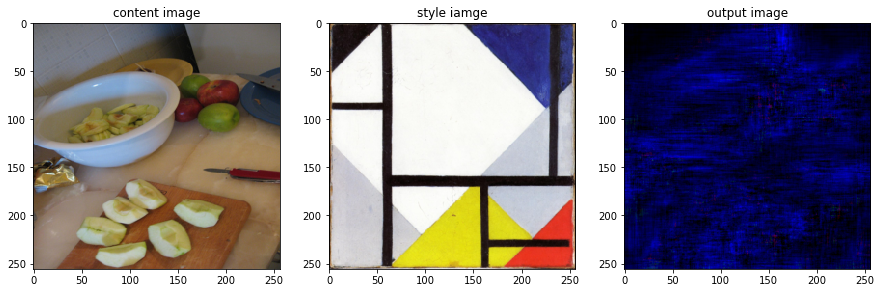

------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
step 5000 ,time : 3401.9
total loss : 6.166594e+04, content loss : 3.631996e+04, style loss : 2.534597e+04


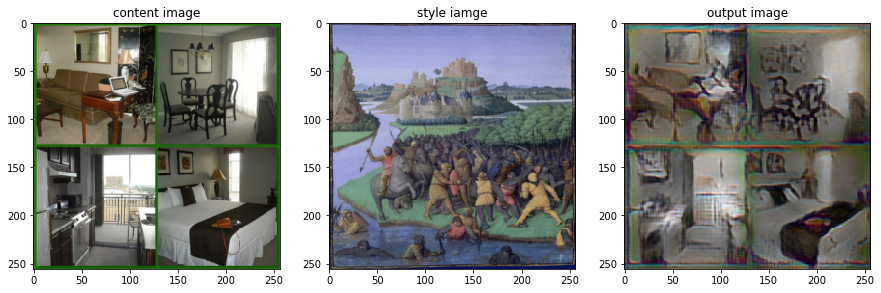

------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
step 10000 ,time : 3371.57
total loss : 8.712126e+04, content loss : 3.246593e+04, style loss : 5.465533e+04


------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
step 15000 ,time : 3387.01
total loss : 7.473010e+04, content loss : 4.317416e+04, style loss : 3.155594e+04


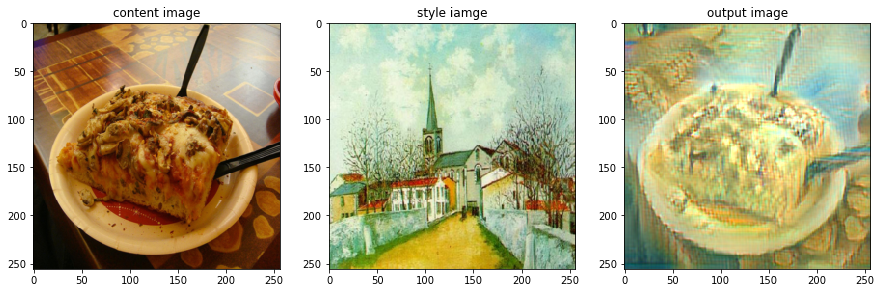

------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
step 20000 ,time : 3382.13
total loss : 7.214262e+04, content loss : 4.161365e+04, style loss : 3.052897e+04


------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
step 25000 ,time : 3376.81
total loss : 8.503692e+04, content loss : 4.693609e+04, style loss : 3.810084e+04


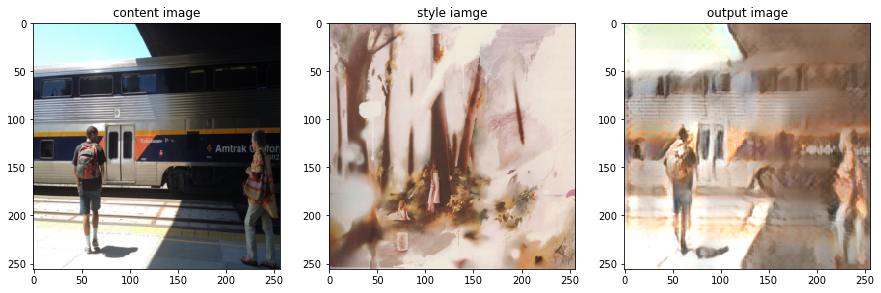

------------------------------ Model saved in file :  v3_model.ckpt ------------------------------
------------------------------ Model saved in file :  v3_model.ckpt ------------------------------


In [11]:

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# # load saved model and retraining
# sess = tf.InteractiveSession()
# saver = tf.train.Saver()
# saver.restore(sess, 'v3_model.ckpt')

# training
for epo in range(EPOCH):
    img_list = os.listdir(COCO_PATH)
    img_list = img_list[:DATA_NUM]
    step = 0 
    t1 = time.time()
    while img_list:
        # make batch images
        img_names = [img_list.pop() for _ in range(BATCH_SIZE)] # get image names
        batch_imgs = [read_img(COCO_PATH+img_name) for img_name in img_names] # read imges : H,W,C
        batch_imgs = np.stack([batch_imgs[i] for i in range(BATCH_SIZE)]) # stack, list to array :  B, H, W, C

        # select style image
        ind = np.random.randint(0, STYLE_NUM)
        sty_img = read_img(STYLE_PATH+'/'+STYLE_NAME_LIST[ind])
        sty_img = np.expand_dims(sty_img, axis=0)
        
        # alpha
        a = np.array([1.],dtype=np.float32).reshape([1,1])
        if step%CHECK_POINT ==0:
            t2 = time.time()
            print('step %d ,time : %4g'%(step,t2-t1))
            t1 = t2
            t_loss,c_loss,s_loss,tout = sess.run([total_loss, cont_loss, sty_loss,generated_img], {content_images:batch_imgs, style_images:sty_img, alpha:a})
            print('total loss : %e, content loss : %e, style loss : %e'%(t_loss, c_loss, s_loss))

            plt.figure(figsize=(15,15))
            plt.subplot(131)
            plt.title('content image')
            plt.imshow(visualize_img(batch_imgs[0,:,:,:]))

            plt.subplot(132)
            plt.title('style iamge')
            plt.imshow(visualize_img(sty_img[0,:,:,:]))

            plt.subplot(133)
            plt.title('output image')
            plt.imshow(visualize_img(tout[0,:,:,:]))
            
           
            plt.show()
        if step%2000 == 0:
            save_path = saver.save(sess, 'v3_model.ckpt')
            print('-'*30, "Model saved in file : ", save_path,'-'*30)

        step += 1
        sess.run(train_step, {content_images:batch_imgs, style_images:sty_img, alpha :a})

#  스타일 테스트

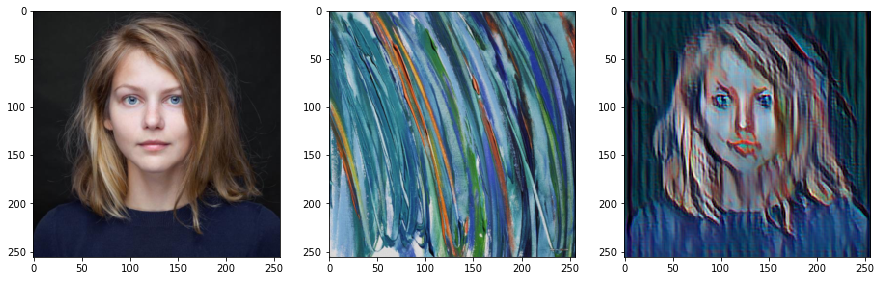

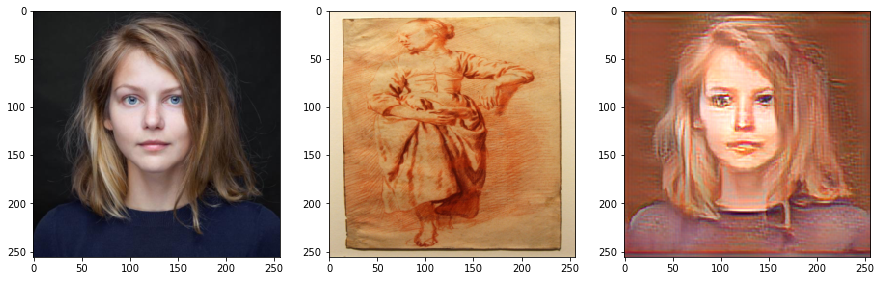

In [83]:
style_path = "style_images"
test_img_lst = os.listdir(style_path)[:3]
for test_img in test_img_lst:
    t_path = style_path+'/'+test_img
    test_sty = read_img(t_path)
    
    plt.figure(figsize=(15,15))
    test_img = read_img('content_images/karya.jpg')
    plt.subplot(131)
    plt.imshow(test_img)
    test_img = np.expand_dims(test_img, axis=0)



    plt.subplot(132)
    plt.imshow(test_sty)
    test_sty = np.expand_dims(test_sty, axis=0)
    

    test_out = sess.run(generated_img, {content_images:test_img, style_images:test_sty, alpha : np.array([1.]).reshape([1,1])})
    plt.subplot(133)
    plt.imshow(visualize_img(test_out[0,:,:,:]))
    plt.show()

# style, content trade off

In [28]:
a_list = [1.0, 0.75, 0.5, 0.25, 0.0]

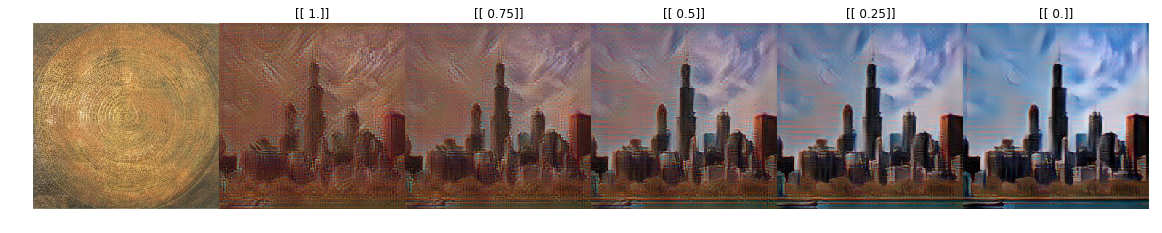

In [48]:
test_sty = read_img(style_path+'/'+test_img_lst[14])
test_sty = np.expand_dims(test_sty, axis=0)
test_img = read_img('content_images/chicago.jpg')
test_img = np.expand_dims(test_img, axis=0)
ind = 2
plt.figure(figsize=(20,20))
plt.subplot(161)
plt.axis('off')
plt.imshow(visualize_img(np.squeeze(test_sty)))
for a in a_list:
    a = np.array(a).reshape([1,1])
    test_out = sess.run(generated_img, {content_images:test_img, style_images:test_sty, alpha : a})
    plt.subplot(1,6,ind)
    plt.axis('off')
    plt.imshow(visualize_img(test_out[0,:,:,:]))
    plt.title(str(a))
    ind += 1
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# color preservation

In [49]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def gray2rgb(gray):
    w, h = gray.shape
    rgb = np.empty((w, h, 3), dtype=np.float32)
    rgb[:, :, 2] = rgb[:, :, 1] = rgb[:, :, 0] = gray
    return rgb

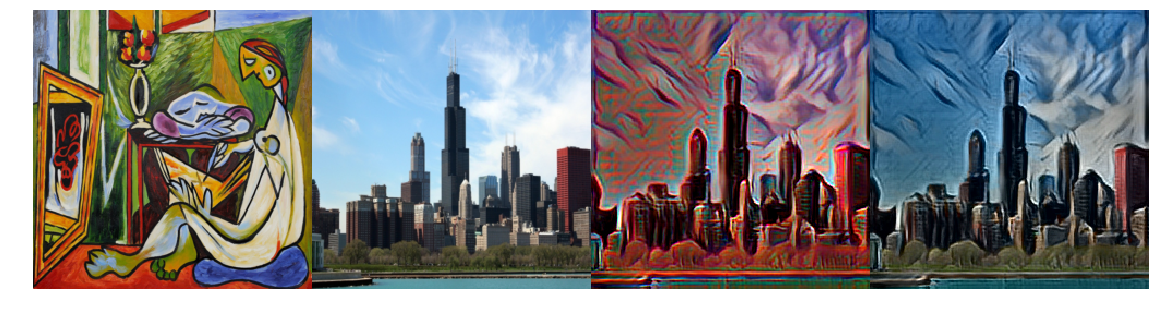

In [76]:
from PIL import Image

test_sty = read_img(style_path+'/'+test_img_lst[14])
test_sty = np.expand_dims(test_sty, axis=0)
test_img = read_img('content_images/chicago.jpg')
test_img = np.expand_dims(test_img, axis=0)

test_out = sess.run(generated_img, {content_images:test_img, style_images:test_sty, alpha : np.array([1]).reshape([1,1])})
test_img = visualize_img(test_img[0,:,:,:])
test_out = visualize_img(test_out[0,:,:,:])

styled_grayscale = rgb2gray(test_out)
styled_grayscale_rgb = gray2rgb(styled_grayscale)

styled_grayscale_yuv = np.array(Image.fromarray(styled_grayscale_rgb.astype(np.uint8)).convert('YCbCr'))
original_yuv = np.array(Image.fromarray(test_img.astype(np.uint8)).convert('YCbCr'))

w, h, _ = test_img.shape
combined_yuv = np.empty((w, h, 3), dtype=np.uint8)
combined_yuv[..., 0] = styled_grayscale_yuv[..., 0]
combined_yuv[..., 1] = original_yuv[..., 1]
combined_yuv[..., 2] = original_yuv[..., 2]

img_out = np.array(Image.fromarray(combined_yuv, 'YCbCr').convert('RGB'))

plt.figure(figsize=(20,20))

plt.subplot(141)
plt.axis('off')
plt.imshow(visualize_img(test_sty[0,:,:,:]))
plt.subplot(142)
plt.axis('off')
plt.imshow(test_img)
plt.subplot(143)
plt.axis('off')
plt.imshow(test_out)
plt.subplot(144)
plt.axis('off')
plt.imshow(img_out)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()